In [3]:
#pip install yfinance scipy plotly matplotlib mplfinance

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf 
import plotly.graph_objects as go
from datetime import datetime
from datetime import date

In [2]:
def  get_option_data(symbol):
    ticker = yf.Ticker(symbol)
    options_dates = ticker.options
    # using the closest expiry date for the analysis
    options_data = ticker.option_chain(options_dates[0])
    return options_data.calls , options_data.puts

jpm_calls , jpm_puts = get_option_data('JPM')
# jpm_calls, jpm_puts

[*********************100%%**********************]  1 of 1 completed


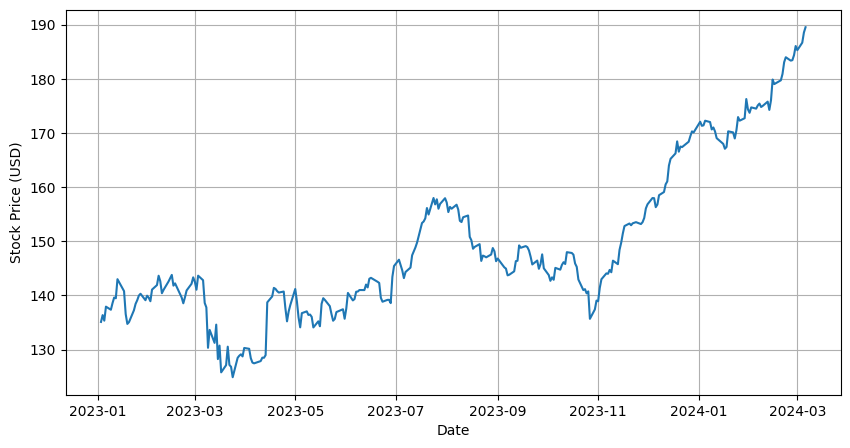

In [3]:
today = date.today()
start_date = '2023-01-01'
jpm_stock_data =  yf.download('JPM', start_date, today)

# plotting the option data
plt.figure( figsize=(10,5))
plt.plot(jpm_stock_data["Close"])
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)

In [6]:
# Defining the Black Scholes Model

class BlackScholesModel:
    def __init__(self,S,K,t,r ,sigma):
        self.K = K  # strike price
        self.S = S  # stock price
        self.t = t  # time to expiration
        self.r = r  # risk free rate
        self.sigma = sigma  # volatility 
        
    def d1(self):
        return (np.log(self.S /self.K)  + (self.r + 0.5 * self.sigma **2)* self.t)/(self.sigma * np.sqrt(self.t))
    
    def d2(self):
        return  self.d1() - self.sigma * np.sqrt(self.t)
    
    def call_option_price(self):
        return  (self.S * si.norm.cdf(self.d1(), 0.0 ,1.0) - self.K * np.exp(-self.r * self.t)*si.norm.cdf(self.d2(),  0.0, 1.0))
    
    def put_option_price(self):
        return (self.K * np.exp(-self.r * self.t) *si.norm.cdf(-self.d2(), 0.0,1.0) - self.S * si.norm.cdf(self.d1()  ,0.0, 1.0))
    

bsm = BlackScholesModel(S = 100, K = 100, t = 1,r = 0.05, sigma =  0.2)
print(bsm.call_option_price())
print(bsm.put_option_price())

10.450583572185565
-21.79260421286685


In [8]:
# function to calculate the volatility 
def calculate_volatility(stock_data ,window = 252  ):
    log_returns =  np.log(stock_data["Close"].pct_change())
    volatility  = np.sqrt(window) *log_returns.std()
    return volatility

jpm_volatility = calculate_volatility(jpm_stock_data)
print(jpm_volatility)

15.667103265830935


c:\ACADEMICS\Trading\Projects\Portfolio-Optimization-App\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
class BlackScholesGreeks(BlackScholesModel):
    def delta_call(self):
        return si.norm.cdf(self.d1() , 0.0, 1.0)
    
    def delta_put(self):
        return -si.norm.cdf(-self.d1() , 0.0, 1.0)
    
    def gamma(self):
        return (si.norm.pdf(self.d1(),0.0,1.0)/(self.sigma*self.S*np.sqrt(self.t)))
    
    def theta_call(self):
        return (-(self.S*self.sigma*si.norm.pdf(self.d1(),0.0,1.0)/ (2*np.sqrt(self.t))) - self.r*self.K.np.exp(-self.r*self.t)*si.norm.cdf(self.d2(),0.0,1.0))/self.t
    
    def theta_put(self):
        return (-(self.S*self.sigma*si.norm.pdf(self.d1(),0.0,1.0)/ (2*np.sqrt(self.t))) + self.r*self.K.np.exp(-self.r*self.t)*si.norm.cdf(-self.d2(),0.0,1.0))/self.t
    
    def vega(self):
        return (self.S*np.sqrt(self.t)*si.norm.pdf(self.d1(),0.0,1.0))/100
    
    def rho_call(self):
        return (self.K*self.t*np.exp(-self.r*self.t*si.norm.cdf(self.d2(),0.0,1.0)))/100
    
    def rho_put(self):
        return -(self.K*self.t*np.exp(-self.r*self.t*si.norm.cdf(-self.d2(),0.0,1.0)))/100
    
bsg =BlackScholesGreeks( S= 100 ,  K =100,  t =1 ,r = 0.05,sigma =0.2)
print(bsg.delta_call())
print(bsg.delta_put())

0.6368306511756191
-0.3631693488243809


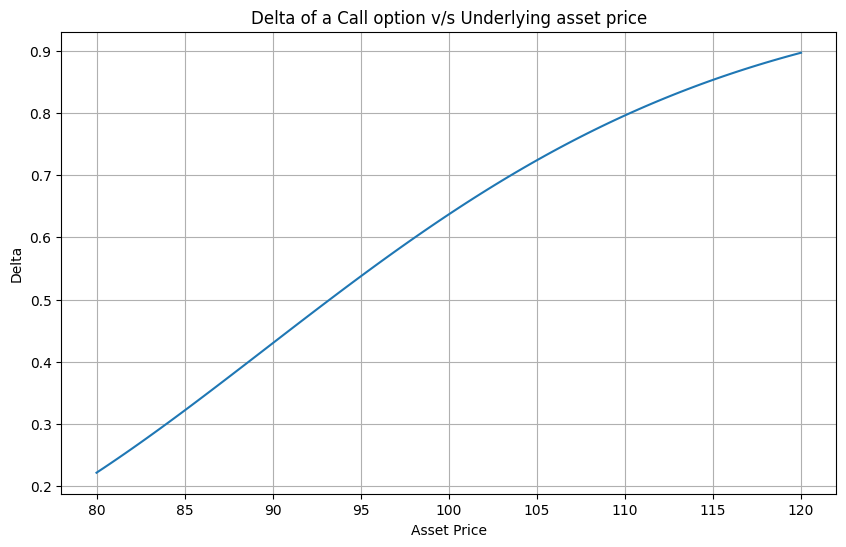

In [14]:
stock_prices =  np.linspace(80,120,100)
deltas = [BlackScholesGreeks(S =price,  K =100, t =1,r = 0.05,sigma = 0.2 ).delta_call() for price in  stock_prices]

plt.figure(figsize=(10,6))
plt.plot(stock_prices, deltas)
plt.title("Delta of a Call option v/s Underlying asset price")
plt.xlabel("Asset Price")
plt.ylabel("Delta")
plt.grid(True)

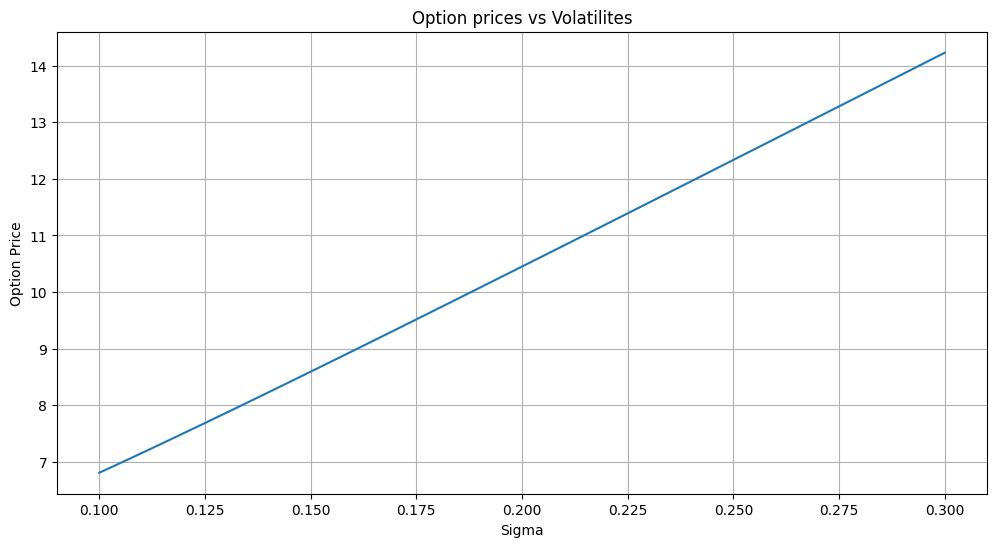

In [15]:
def plot_option_senstivity(bs_model,  parameter, values, option_type = "call"):
    prices =  []
    for value in values:
        setattr(bs_model,  parameter, value)
        if option_type == "call":
            prices.append(bs_model.call_option_price())
        else:
            prices.append(bs_model.put_option_price())
    
    plt.figure(figsize =(12,6))
    plt.plot(values , prices)
    plt.title("Option prices vs Volatilites")
    plt.xlabel("Sigma")
    plt.ylabel("Option Price")
    plt.grid(True)
    
volatilities = np.linspace(0.1,0.3,100)
plot_option_senstivity(bsm,"sigma" ,volatilities, "call")

Text(0, 0.5, 'Option Price')

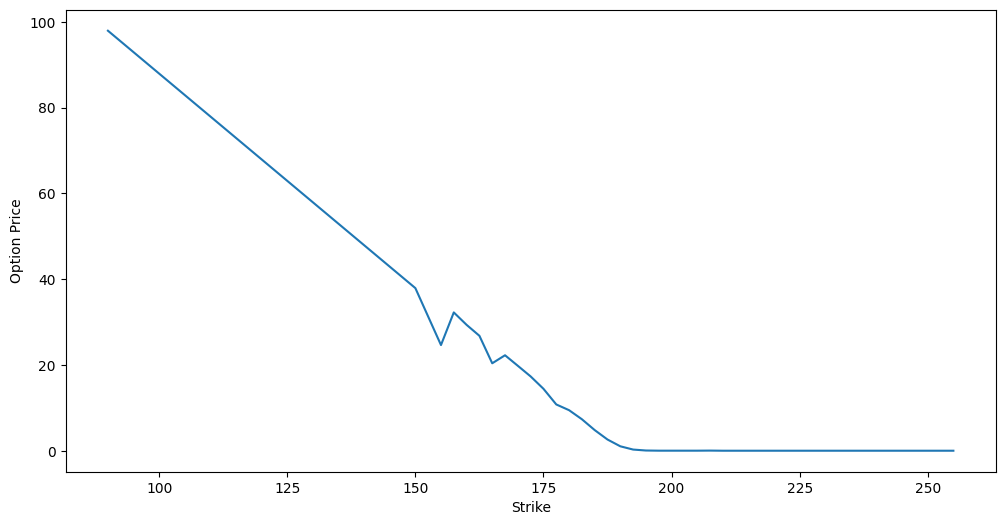

In [25]:
plt.figure(figsize= (12,6))
plt.plot(jpm_calls["strike"]  ,jpm_calls['lastPrice'])
plt.plot(bsm.call_option_price())
plt.xlabel("Strike")
plt.ylabel("Option Price")

In [21]:
jpm_calls['lastTradeDate'][1]

Timestamp('2024-03-04 16:15:54+0000', tz='UTC')

In [47]:
jpm_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,JPM240308C00090000,2024-03-05 16:49:42+00:00,90.0,97.95,0.0,0.0,0.0,0.0,15.0,0,0.00001,True,REGULAR,USD
1,JPM240308C00150000,2024-03-04 16:15:54+00:00,150.0,37.93,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD
2,JPM240308C00155000,2024-02-16 15:06:58+00:00,155.0,24.65,0.0,0.0,0.0,0.0,8.0,0,0.00001,True,REGULAR,USD
3,JPM240308C00157500,2024-03-06 18:36:01+00:00,157.5,32.26,0.0,0.0,0.0,0.0,2.0,0,0.00001,True,REGULAR,USD
4,JPM240308C00160000,2024-03-06 16:28:03+00:00,160.0,29.36,0.0,0.0,0.0,0.0,10.0,0,0.00001,True,REGULAR,USD


Series([], Name: lastPrice, dtype: float64)

In [61]:
=

TypeError: 'Timestamp' object cannot be interpreted as an integer

In [54]:
from datetime import datetime
import pandas as pd

# Example Series containing datetime strings
datetime_series = pd.Series(["2024-03-05 16:49:42+00:00", "2024-03-06 18:36:01+00:00"])

# Function to convert each datetime string to date
def convert_to_date(datetime_string):
    datetime_object = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M:%S%z")
    return datetime_object.date()

# Apply the function to each element of the Series
date_series = datetime_series.apply(convert_to_date)

print(date_series)
print(datetime_series)


0    2024-03-05
1    2024-03-06
dtype: object
0    2024-03-05 16:49:42+00:00
1    2024-03-06 18:36:01+00:00
dtype: object
